#ML for Earth System Science-19EE10039
MANSI UNIYAL

A1. Spatial Process

Consider a square region of size 20x20 and 100 time-steps. 

1) At t=1, select 10 random locations (likely to be different for all students). Put down observed values X(s,t) according to the formula X(s,t) = s1+s2+random noise, where s1, s2 are the horizontal and vertical positions of the location s in the square.

2) Using this initial data, use a Gaussian Process to generate data for the whole region (fitting the initial data) and for all the time-points.

3) Once the data has been generated, pick up a random set of 20 locations. Consider that you 
know the values at these locations for all time-points. Use kriging to estimate the values at 
other locations. Compare the estimated values with generated values.

A2. Spatio-temporal process Repeat the initialization of step 1 of A1, at 5 random time-points and 5 
spatial locations (25 points overall), setting X(s,t) = s1+s2+0.5*t + random noise. Repeat step 2 using 
spatio-temporally separable Gaussian Processes (i.e. decompose as a product of two GPs – one spatial 
and one temporal). Explain how the generated dataset is different from the dataset obtained in Step 2.


##import libraries

In [77]:
!pip install pykrige

In [78]:
import numpy as np
import subprocess
import os
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pykrige
from mpl_toolkits import mplot3d
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from pykrige.rk import RegressionKriging
from pykrige.uk import UniversalKriging

seed = 10039    #roll number endings

##A1.1

In [79]:
np.random.seed(seed)

coords = np.random.uniform(0, 20, size = (10,2))
coords = np.floor(coords)
print('coordinates:\n', coords)

a1_x = np.reshape(np.sum(coords, axis = 1), (10,1))
a1_x =  a1_x + np.random.normal(size=(10,1))
print("\na1_x: \n",a1_x)

print('\n', np.shape(a1_x))

coordinates:
 [[ 3.  4.]
 [12. 14.]
 [19. 12.]
 [ 4.  6.]
 [19.  1.]
 [11. 15.]
 [15.  1.]
 [16.  3.]
 [ 8.  8.]
 [ 4. 11.]]

a1_x: 
 [[ 7.86605401]
 [24.19798213]
 [29.35197119]
 [10.33679166]
 [19.6843821 ]
 [27.21113744]
 [15.91257843]
 [18.75938271]
 [16.8231621 ]
 [13.77389316]]

 (10, 1)


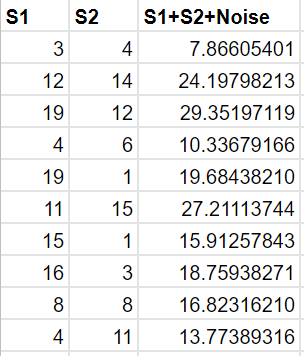

##A1.2

In [80]:
a1_x =  a1_x + np.random.normal(size=(10,100))
print( np.shape(a1_x),'\n')

(10, 100) 



In [81]:
kernel = 1*RBF()
gaussian_model = GaussianProcessRegressor(kernel = kernel, random_state = seed)
gaussian_model.fit(coords, a1_x)

print("RBF:\n\n Parameters of Kernel before fit:\n",kernel, 
      "\n\n Parameters of Kernel after fit: \n", gaussian_model.kernel_, 
      "\n\n Log-likelihood:", gaussian_model.log_marginal_likelihood(gaussian_model.kernel_.theta) )

RBF:

 Parameters of Kernel before fit:
 1**2 * RBF(length_scale=1) 

 Parameters of Kernel after fit: 
 20.1**2 * RBF(length_scale=7.9) 

 Log-likelihood: -3470.2489750390196


In [82]:
#trying other kernels
kernel = 1*RationalQuadratic()
gaussian_model_2 = GaussianProcessRegressor(kernel = kernel, random_state = seed)
gaussian_model_2.fit(coords, a1_x)

print("RationalQuadratic:\n\n Parameters of Kernel before fit:\n",kernel, 
      "\n\n Parameters of Kernel after fit: \n", gaussian_model_2.kernel_, 
      "\n\n Log-likelihood:", gaussian_model_2.log_marginal_likelihood(gaussian_model_2.kernel_.theta) )

RationalQuadratic:

 Parameters of Kernel before fit:
 1**2 * RationalQuadratic(alpha=1, length_scale=1) 

 Parameters of Kernel after fit: 
 21.7**2 * RationalQuadratic(alpha=0.0498, length_scale=14.2) 

 Log-likelihood: -3105.0968179264933


In [83]:
def func(x,y,t):
    Z = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        mean, std = gaussian_model.predict(np.column_stack((X[i], Y[i])), return_std = True)
        y = np.random.normal(loc = mean[:,t-1], scale = std)
        Z[i] = y;
    return Z

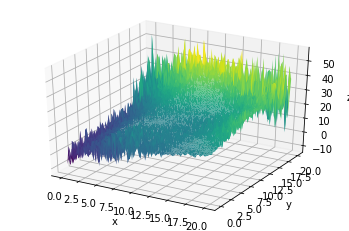

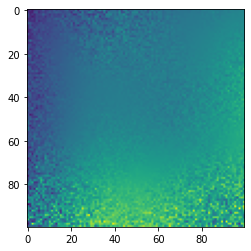

In [84]:
fig = plt.figure()

x = np.linspace(0, 20, 100)
y = np.linspace(0, 20, 100)

X, Y = np.meshgrid(x, y)



Z = func(x,y,1) #pred

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


fig = plt.figure()
plt.imshow(Z)
plt.show()

##A1.3

In [85]:
loc_3 = np.random.uniform(0, 20, size = (20,2))

mean,std = gaussian_model.predict(loc_3,return_std=True)
std = std.reshape((std.shape[0],1))
y = np.random.normal(loc = mean, scale = std)
print(y.shape)

x_d = np.ones((loc_3.shape[0], 100))*(loc_3[:,0].reshape(loc_3.shape[0], 1))
x_d = x_d.flatten('F')
y_d = np.ones((loc_3.shape[0], 100))*(loc_3[:,1].reshape(loc_3.shape[0], 1))
y_d = y_d.flatten('F')

val = y.flatten('F')

(20, 100)


/usr/local/lib/python3.7/dist-packages/pykrige/core.py:853: RuntimeWarning: invalid value encountered in sqrt
  sigma[i] = np.sqrt(ss)


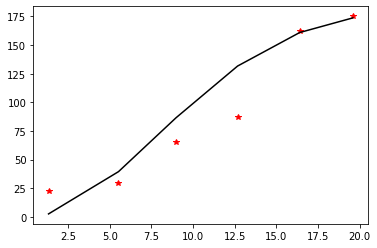

In [86]:
krig_model = UniversalKriging(x_d,y_d,val,variogram_model="gaussian")
krig_model.display_variogram_model()

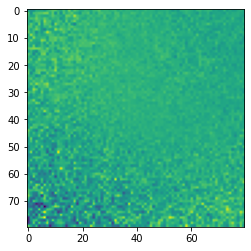

In [87]:
gridx = np.arange(0.0, 20, 0.25)
gridy = np.arange(0.0, 20, 0.25)

z, ss = krig_model.execute("grid", gridx, gridy)
plt.imshow(z)
plt.show()

In [88]:
loc_points = np.random.uniform(0, 20, size = (15,2))
ke,ks = krig_model.execute("points", loc_points[:,0], loc_points[:,1])
print('estimated\n:',ke,'\n')

ge = gaussian_model.predict(loc_points)
print('rbf:\n',ge[:,0],'\n')
ge2 = gaussian_model_2.predict(loc_points)
print('RationalQuadratic:\n',ge2[:,0],'\n')

print("R2 Score(Correlation)rbf: ",r2_score(ge[:,0],ke)) #approx 1, highly correlated
print("R2 Score(Correlation)RationalQuadratic: ",r2_score(ge2[:,0],ke)) #approx 1, highly correlated

estimated
: [99870.47746489935 184682.86380065032 151250.05107367228
 -273488.06104892923 88180.79705478415 72976.46532423368
 -107672.89619148074 7040.042524232058 155596.37320561812
 105769.79790147486 115037.0370814319 63662.64193425646 103888.0136110092
 66394.3877146395 105520.03764118625] 

rbf:
 [15.80185866  1.900475   34.76283707 19.43737412 20.1568245  15.87048526
 23.69885892 33.61982206 11.24673591  5.77666538 13.42931035  4.77159955
 17.83484436 24.00055898 28.82130137] 

RationalQuadratic:
 [15.41260541  7.07343817 29.36804782 20.15816631 21.30441346 15.09435408
 21.11801111 28.54515577  9.99277497  9.69581076 13.17446078 12.33524001
 20.8172209  21.17378222 28.52096138] 

R2 Score(Correlation)rbf:  -178322021.37132317
R2 Score(Correlation)RationalQuadratic:  -342645028.01930416


##A2

In [89]:
tp = np.random.randint(1,101,size=5)
loc_points = np.random.uniform(0,20, size = (5,2))
loc_points=np.floor(loc_points)

features = []
for x,y in loc_points:
    for t in tp:
        features.append([x,y,t])
        
features = np.array(features)

In [90]:
a2_x = np.sum(features[:,:-1],axis = 1)
a2_x = a2_x + 0.5* features[:,-1] + np.random.normal(size=a2_x.shape[0])

In [91]:
a2_x #generated sample input

array([13.84819096, 19.91300354, 33.98560403, 25.15784814, 32.92483902,
       37.2814171 , 43.78823059, 56.84653079, 48.02567863, 55.10861251,
       34.29633568, 37.03493693, 55.64268076, 43.31340378, 50.67474101,
       38.10501374, 40.71452739, 57.3134066 , 46.36704104, 55.08685068,
       33.64086286, 38.67368221, 55.3976181 , 41.58656943, 50.52004025])

In [92]:
kernel_s = 1*RBF()
kernel_t = 0.5*RBF()
gaussian_model = GaussianProcessRegressor(kernel = kernel_s*kernel_t, random_state = seed)
gaussian_model.fit(features,a2_x)

print(" Parameters of Kernel before fit:\n",kernel, 
      "\n\n Parameters of Kernel after fit: \n", gaussian_model.kernel_, 
      "\n\n Log-likelihood:", gaussian_model.log_marginal_likelihood(gaussian_model.kernel_.theta) )

 Parameters of Kernel before fit:
 1**2 * RationalQuadratic(alpha=1, length_scale=1) 

 Parameters of Kernel after fit: 
 1**2 * RBF(length_scale=1) * 0.707**2 * RBF(length_scale=1) 

 Log-likelihood: -40695.27904513083


As particular dimension at every time point thus,  generated dataset in this is different from the previous state